In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text

In [ ]:
import os

os.listdir('/home/yz685/corr_pooling_seirsplus/results/')

In [3]:
import pickle

NUM_TRIALS = 20


param_config = {
    "country": ["US"],

    "pop_size_default": 10000,

    "init_prev": [0.001, 0.01],
    "init_prev_default": 0.01,

    'horizon_default': 100,

    "num_groups_default": 5,
    "num_groups": [1,2,3,4,5,6,7],

    'pool_size': [5,10,20,30],
    'pool_size_default': 10,

    'LoD_default': 1240,
    'LoD': [1240],

    "edge_weight_default": 10,
    "edge_weight": [10],

    "alpha_default": 5.0,
    "alpha": [2.0],

    "peak_VL": [6.0],

    "distancing_scale": [50.0],

    "beta_default": 0.1, # transmissibility
    "sigma_default": 0.2, # rate E --> I_pre
    "lamda_default": 0.5, # rate I_pre --> I_(a)sym
    "gamma_default": 0.25 # rate I_sym --> R
}


In [4]:
import itertools

param_values = {}

for param in [
        "country", "pop_size", "init_prev", "num_groups", "pool_size", "horizon", 
        "beta", "sigma", "lamda", "gamma", "LoD", "edge_weight", "alpha", "peak_VL",
        "distancing_scale"
    ]:
        if param in param_config:
            param_values[param] = param_config[param]
        else:
            param_values[param] = [param_config[param+"_default"]]

all_param_configs = [dict(zip(param_values.keys(), x)) for x in itertools.product(*param_values.values())]

In [5]:
import copy
from collections import defaultdict
def defaultdict_list():
    return defaultdict(list)

# paths = []

df_data = []

all_data = []
trajectories = [] # list of tuples (dict of param_config_single, dict of {metric: [mean, std]})

for param_config_single in all_param_configs:

    traj_info = [param_config_single, {}]
    
    path = f"/home/yz685/corr_pooling_seirsplus/results/{param_config_single['country']}"
    for param in [
        "pop_size", "init_prev", "num_groups", "pool_size", "horizon", 
        "beta", "sigma", "lamda", "gamma", "LoD", "edge_weight", "alpha", "peak_VL", "distancing_scale"
    ]:
        path += f"_{param}={param_config_single[param]}"

    data = copy.deepcopy(param_config_single)

    # paths.append(path)

    results = defaultdict(list)

    for pooling_strategy in ["naive", "correlated", "correlated_weak"]:
        for i in range(1, NUM_TRIALS+1):
            filepath = path + f"/{pooling_strategy}/results_{i}.pickle"
            try:
                with open(filepath, "rb") as f:
                    results[pooling_strategy].append(pickle.load(f))
            except Exception as e:
                # print("error: ", e)
                continue

    if len(results["naive"]) == 0:
        continue

    metrics = set(results["correlated"][0][0].keys()) - set(["day", "VL_in_positive_pools"])

    for metric in metrics:
    # for metric in ["cumInfections", "cum_num_tests", "daily_sensitivity", "numActiveInfections", "mean_num_positives_in_positive_pool"]:
        
        for pooling_strategy in ["naive", "correlated", "correlated_weak"]:

            # print(pooling_strategy, metric)

            results_tmp = []
            for SEED in range(NUM_TRIALS):
                try:
                    results_tmp.append(
                        [x[metric]\
                        for x in results[pooling_strategy][SEED]]
                    )
                except:
                    pass

            results_tmp_ = np.array([(xi+[None]*(100-len(xi)))[:100] for xi in results_tmp], dtype=float)
            mean = np.nanmean(results_tmp_, axis=0)
            sem = np.nanstd(results_tmp_, axis=0)/np.sqrt(NUM_TRIALS)
            traj_info[1][metric+"_"+pooling_strategy] = [mean, sem] # TODO: confirm

            if metric in ["cumInfections", "cum_num_tests"]:
                data[f"{metric}_{pooling_strategy}_mean"] = mean[-1]
                data[f"{metric}_{pooling_strategy}_sem"] = sem[-1]
            else:
                data[f"{metric}_{pooling_strategy}_mean"] = np.nanmean(mean)
                data[f"{metric}_{pooling_strategy}_sem"] = np.nanmean(sem)

    all_data.append(data)
    trajectories.append(traj_info)


In [12]:
traj_info[0]

{'country': 'US',
 'pop_size': 10000,
 'init_prev': 0.01,
 'num_groups': 7,
 'pool_size': 30,
 'horizon': 100,
 'beta': 0.1,
 'sigma': 0.2,
 'lamda': 0.5,
 'gamma': 0.25,
 'LoD': 1240,
 'edge_weight': 10,
 'alpha': 2.0,
 'peak_VL': 6.0,
 'distancing_scale': 50.0}

In [11]:
for i, j in enumerate(traj_info[1].keys()):
    print(i,j)

0 cum_num_tests_naive
1 cum_num_tests_correlated
2 cum_num_tests_correlated_weak
3 median_num_identifiable_positives_in_positive_pool_naive
4 median_num_identifiable_positives_in_positive_pool_correlated
5 median_num_identifiable_positives_in_positive_pool_correlated_weak
6 daily_effective_followup_efficiency_naive
7 daily_effective_followup_efficiency_correlated
8 daily_effective_followup_efficiency_correlated_weak
9 mean_num_positives_in_positive_pool_naive
10 mean_num_positives_in_positive_pool_correlated
11 mean_num_positives_in_positive_pool_correlated_weak
12 num_susceptible_neighbors_of_unidentified_positives_naive
13 num_susceptible_neighbors_of_unidentified_positives_correlated
14 num_susceptible_neighbors_of_unidentified_positives_correlated_weak
15 cumInfections_naive
16 cumInfections_correlated
17 cumInfections_correlated_weak
18 mean_num_identifiable_positives_in_positive_pool_naive
19 mean_num_identifiable_positives_in_positive_pool_correlated
20 mean_num_identifiable_pos

In [6]:

metric_to_english = {
    "cumInfections": "cumulative infections",
    "cum_num_tests": "cumulative test consumption",
    "daily_sensitivity": r"daily sensitivity ($1-\beta$)",
    "numActiveInfections": "active infections",
    "mean_num_positives_in_positive_pool": "mean # positives in positive pools",
    "median_num_positives_in_positive_pool": "median # positives in positive pools",
    "mean_num_identifiable_positives_in_positive_pool": "mean # identifiable positives in positive pools",
    "daily_effective_efficiency": r"daily effective efficiency ($\gamma$)",
    "daily_effective_followup_efficiency": r"daily effective followup efficiency ($\eta$)",
    "num_susceptible_neighbors_of_identified_positives": "# susceptible neighbors of identified positives",
}

colors = {
    "naive": "mediumpurple",
    "correlated": "mediumseagreen",
    "correlated_weak": "dodgerblue",
}

legends_dict = {
    "naive": "naive pooling",
    "correlated": "household correlated pooling",
    "correlated_weak": "community correlated pooling",
}

In [6]:




def plot_trajectory(traj_info, metrics_to_plot = None, pooling_methods = ["naive", "correlated_weak", "correlated"], save_fig=False):

    plt.rcParams["font.family"] = 'serif'

    if metrics_to_plot == None:
        metrics_to_plot = traj_info[1].keys()

    # print(f"init_prev={traj_info[0]['init_prev']}, peak_VL={traj_info[0]['peak_VL']}, num_groups={traj_info[0]['num_groups']}, alpha={traj_info[0]['alpha']}, pool_size={traj_info[0]['pool_size']}, LoD={traj_info[0]['LoD']}, edge_weight={traj_info[0]['edge_weight']}, distancing_scale={traj_info[0]['distancing_scale']}")
    print(f"num_groups={traj_info[0]['num_groups']}, pool_size={traj_info[0]['pool_size']}")

    fig, axs = plt.subplots(2, (len(metrics_to_plot)+1)//2, figsize=(5*len(metrics_to_plot)/2, 3*2))
    fig.tight_layout(pad=2.5)
    fig.subplots_adjust(wspace=0.18)
    # fig.subplots_adjust(hspace=0.4)

    
    for i, metric in enumerate(metrics_to_plot):

        row_idx = i // ((len(metrics_to_plot)+1)//2)
        col_idx = i % ((len(metrics_to_plot)+1)//2)

        for pooling_method in pooling_methods:
            mean = traj_info[1][metric+"_"+pooling_method][0]
            sem = traj_info[1][metric+"_"+pooling_method][1]
            axs[row_idx][col_idx].plot(mean, label=legends_dict[pooling_method], color=colors[pooling_method])
            axs[row_idx][col_idx].fill_between(
                range(len(mean)),
                mean-2*sem,
                mean+2*sem,
                alpha=0.2,
                color=colors[pooling_method]
            )
        axs[row_idx][col_idx].set_xlabel("day", fontsize=12, labelpad=0.2)

        axs[row_idx][col_idx].set_title(metric_to_english[metric], fontsize=14)
        if row_idx == 1 and col_idx == 2:
            axs[row_idx][col_idx].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.3, fontsize=14)

    fig.delaxes(axs[1,3])

    if save_fig:
        plt.savefig("../../figures/dynamic_sim.pdf", bbox_inches='tight')

In [33]:
infection_consumption_ratios = []
gammas = []
gammas_avg = []
approx_efficiencies_avg = []

# pm = "correlated"
pm = "naive"

for j in range(len(trajectories)):
    num_groups = trajectories[j][0]["num_groups"]

    gamma = trajectories[j][1]["daily_effective_efficiency"+"_"+pm][0][-1]
    gamma_avg = np.mean(trajectories[j][1]["daily_effective_efficiency"+"_"+pm][0])
    cumInfections = trajectories[j][1]["cumInfections"+"_"+pm][0][-1]
    cum_num_tests = trajectories[j][1]["cum_num_tests"+"_"+pm][0][-1]

    gammas.append(gamma)
    gammas_avg.append(gamma_avg)
    infection_consumption_ratios.append(cumInfections/cum_num_tests)
    approx_efficiencies_avg.append(10000*100 / num_groups / cum_num_tests)

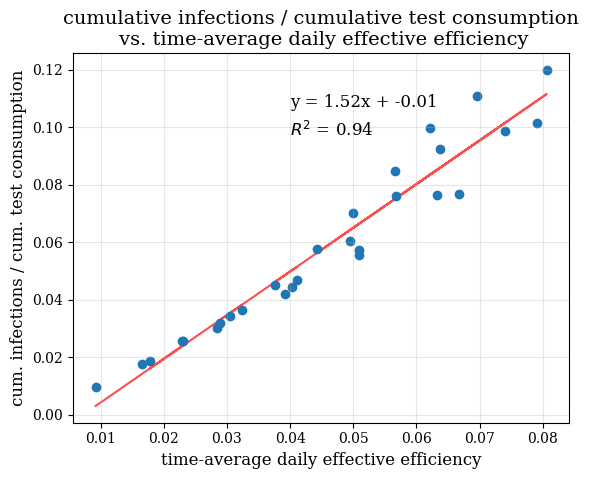

In [39]:
from sklearn.linear_model import LinearRegression

plt.rcParams["font.family"] = 'serif'

plt.grid(alpha=0.3)

X = np.array(gammas_avg).reshape(-1,1)
y = np.array(infection_consumption_ratios).reshape(-1,1)

plt.scatter(X, y)
plt.xlabel("time-average daily effective efficiency", fontsize=12)
plt.ylabel("cum. infections / cum. test consumption", fontsize=12)

model = LinearRegression()
model.fit(X, y)

slope = model.coef_[0][0]
intercept = model.intercept_[0]
equation = f'y = {slope:.2f}x + {intercept:.2f}'
R2 = model.score(X,y)
plt.text(0.04, 0.107, equation, fontsize=12)
plt.text(0.04, 0.097, f'$R^2$ = {R2:.2f}', fontsize=12)

plt.plot(X, model.predict(X), color='red', label='Regression Line', alpha=0.7, zorder=0)

plt.title("cumulative infections / cumulative test consumption\n vs. time-average daily effective efficiency", fontsize=14)

plt.savefig("../../figures/inf_test_ratio_vs_gamma.pdf", bbox_inches='tight')

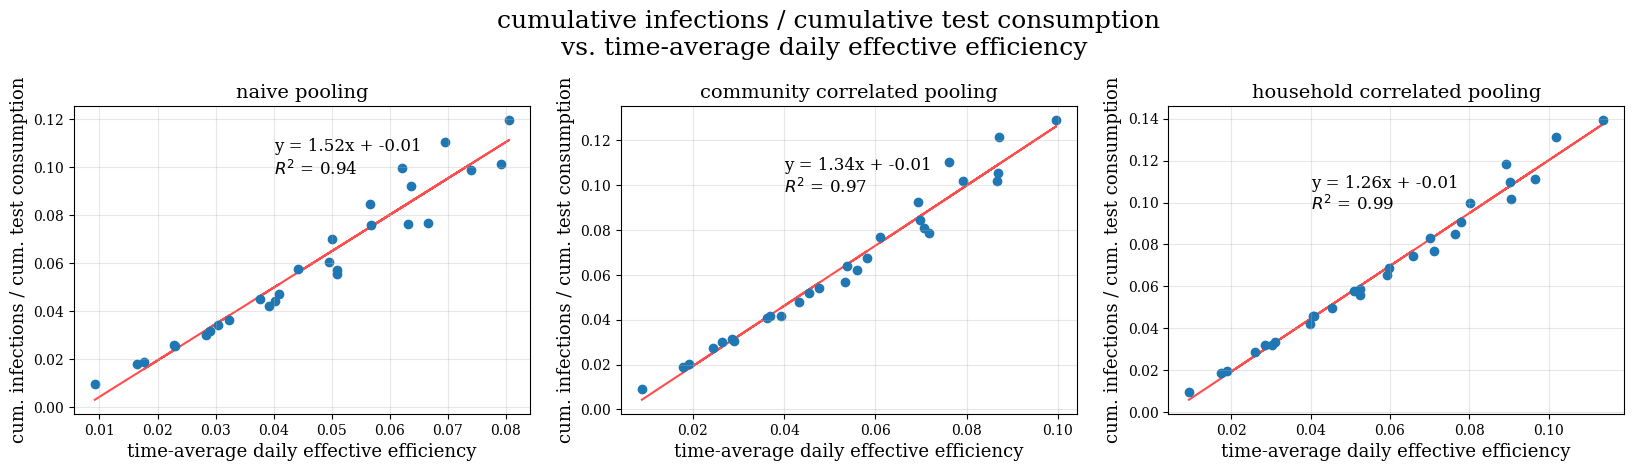

In [57]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4))
plt.rcParams["font.family"] = 'serif'



for i, pm in enumerate(["naive", "correlated_weak", "correlated"]):

    infection_consumption_ratios = []
    gammas = []
    gammas_avg = []
    approx_efficiencies_avg = []

    for j in range(len(trajectories)):
        num_groups = trajectories[j][0]["num_groups"]

        gamma = trajectories[j][1]["daily_effective_efficiency"+"_"+pm][0][-1]
        gamma_avg = np.mean(trajectories[j][1]["daily_effective_efficiency"+"_"+pm][0])
        cumInfections = trajectories[j][1]["cumInfections"+"_"+pm][0][-1]
        cum_num_tests = trajectories[j][1]["cum_num_tests"+"_"+pm][0][-1]

        gammas.append(gamma)
        gammas_avg.append(gamma_avg)
        infection_consumption_ratios.append(cumInfections/cum_num_tests)
        approx_efficiencies_avg.append(10000*100 / num_groups / cum_num_tests)

    X = np.array(gammas_avg).reshape(-1,1)
    y = np.array(infection_consumption_ratios).reshape(-1,1)

    axs[i].grid(alpha=0.3)
    axs[i].scatter(X, y)
    axs[i].set_xlabel("time-average daily effective efficiency", fontsize=13)
    axs[i].set_ylabel("cum. infections / cum. test consumption", fontsize=13)

    model = LinearRegression()
    model.fit(X, y)

    slope = model.coef_[0][0]
    intercept = model.intercept_[0]
    equation = f'y = {slope:.2f}x + {intercept:.2f}'
    R2 = model.score(X,y)
    axs[i].text(0.04, 0.107, equation, fontsize=12)
    axs[i].text(0.04, 0.097, f'$R^2$ = {R2:.2f}', fontsize=12)

    axs[i].plot(X, model.predict(X), color='red', label='Regression Line', alpha=0.7, zorder=0)

    axs[i].set_title(f"{legends_dict[pm]}", fontsize=14)

fig.suptitle(' cumulative infections / cumulative test consumption\n vs. time-average daily effective efficiency ', y = 1.12, fontsize=18)

plt.savefig("../../figures/inf_test_ratio_vs_gamma.pdf", bbox_inches='tight')

In [23]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(np.array(gammas_avg).reshape(-1,1), np.array(infection_consumption_ratios).reshape(-1,1))

In [26]:
reg.score(np.array(gammas_avg).reshape(-1,1), np.array(infection_consumption_ratios).reshape(-1,1))

0.9863315956730139

Text(0, 0.5, 'Cumulative infections / Cumulative test consumption')

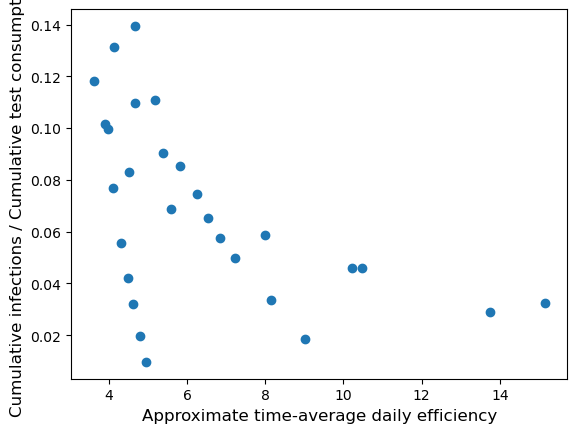

In [21]:
plt.scatter(approx_efficiencies_avg, infection_consumption_ratios)
plt.xlabel("Approximate time-average daily efficiency", fontsize=12)
plt.ylabel("Cumulative infections / Cumulative test consumption", fontsize=12)

num_groups=5, pool_size=20


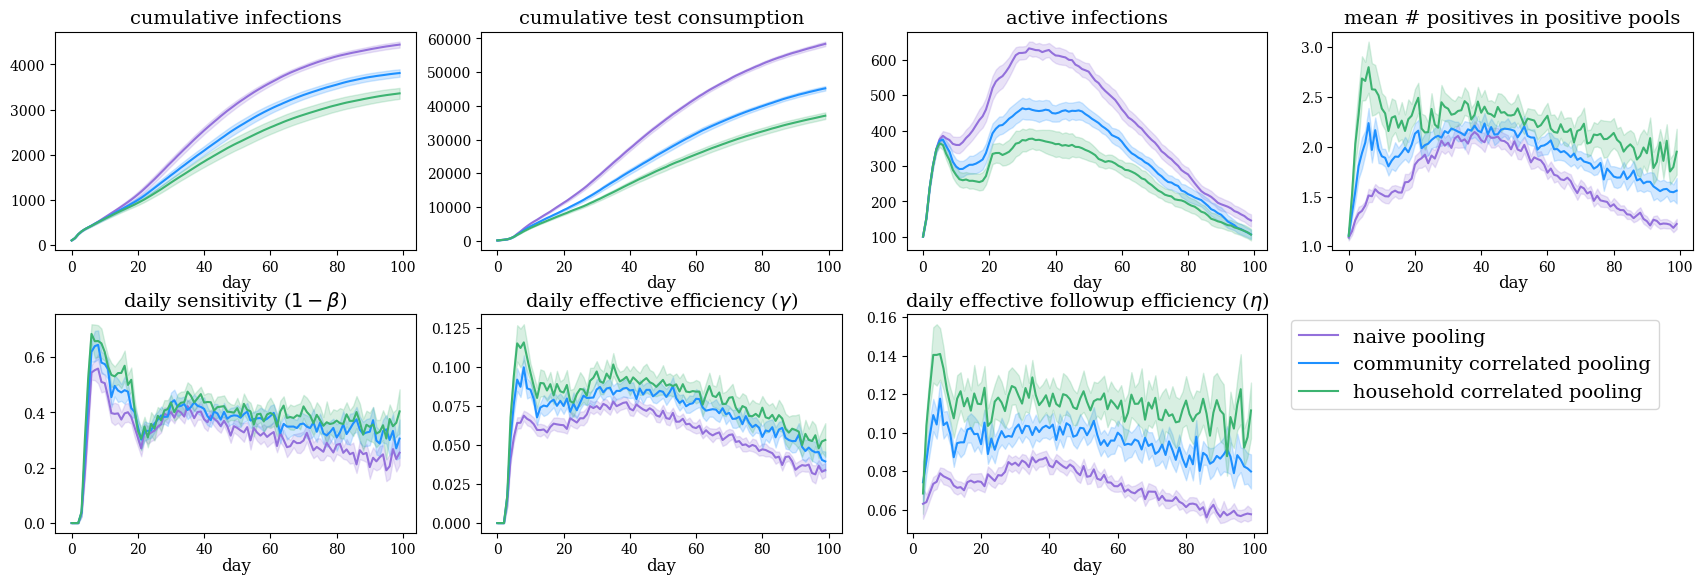

In [73]:
for j in range(len(trajectories)):
    if trajectories[j][0]["distancing_scale"] == 50 and trajectories[j][0]["num_groups"] == 5 and trajectories[j][0]["pool_size"] == 20:
        plot_trajectory(
            trajectories[j], 
            metrics_to_plot = [
                "cumInfections", 
                "cum_num_tests", 
                "numActiveInfections",
                # "mean_num_identifiable_positives_in_positive_pool",
                "mean_num_positives_in_positive_pool",
                # "median_num_positives_in_positive_pool", 
                "daily_sensitivity",
                "daily_effective_efficiency", 
                "daily_effective_followup_efficiency",
                # "mean_num_positives_in_positive_pool",
                # "num_susceptible_neighbors_of_unidentified_positives"
                
                # "cum_positives_identified"
                # "num_susceptible_neighbors_of_identified_positives"
            ],
            save_fig=True
        )



In [8]:
import pandas as pd
df = pd.DataFrame(all_data)
# df.dropna(inplace=True)


In [22]:
df[
    [
        "num_groups", "pool_size", "cumInfections_naive_mean", "cumInfections_correlated_mean", "cumInfections_correlated_weak_mean",]
]

,num_groups,pool_size,cumInfections_naive_mean,cumInfections_correlated_mean,cumInfections_correlated_weak_mean
0,1,5,1962.263158,1952.65,1869.60
1,1,10,2075.650000,2056.35,2158.45
2,1,20,2216.900000,2106.40,2100.10
3,1,30,2234.450000,2128.10,2214.50
4,2,5,2017.850000,2058.10,2121.05
5,2,10,2187.250000,2066.40,1991.00
6,2,20,2304.700000,2198.50,2150.60
7,2,30,2544.800000,2249.35,2313.40
8,3,5,2289.100000,2307.85,2254.25
9,3,10,2409.750000,2301.75,2354.65


In [9]:
for pm1, pm2 in zip(["naive", "naive"], ["correlated", "correlated_weak"]):

    df[f"cumInfections_diff_rel_{pm1}_{pm2}"] = (df[f"cumInfections_{pm1}_mean"] - df[f"cumInfections_{pm2}_mean"])/df[f"cumInfections_{pm1}_mean"]
    df[f"cum_num_tests_diff_rel_{pm1}_{pm2}"] = (df[f"cum_num_tests_{pm1}_mean"] - df[f"cum_num_tests_{pm2}_mean"]) / df[f"cum_num_tests_{pm1}_mean"]


In [12]:
df.columns

Index(['country', 'pop_size', 'init_prev', 'num_groups', 'pool_size',
       'horizon', 'beta', 'sigma', 'lamda', 'gamma',
       ...
       'num_susceptible_neighbors_of_identified_positives_naive_mean',
       'num_susceptible_neighbors_of_identified_positives_naive_sem',
       'num_susceptible_neighbors_of_identified_positives_correlated_mean',
       'num_susceptible_neighbors_of_identified_positives_correlated_sem',
       'num_susceptible_neighbors_of_identified_positives_correlated_weak_mean',
       'num_susceptible_neighbors_of_identified_positives_correlated_weak_sem',
       'cumInfections_diff_rel_naive_correlated',
       'cum_num_tests_diff_rel_naive_correlated',
       'cumInfections_diff_rel_naive_correlated_weak',
       'cum_num_tests_diff_rel_naive_correlated_weak'],
      dtype='object', length=121)

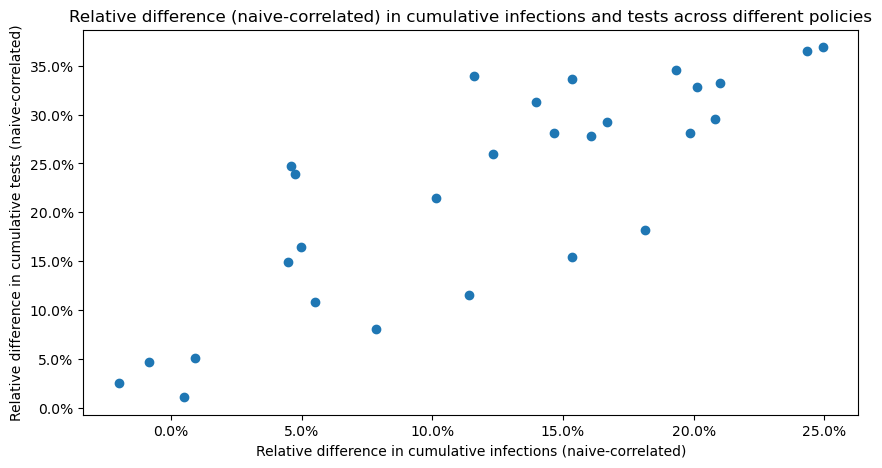

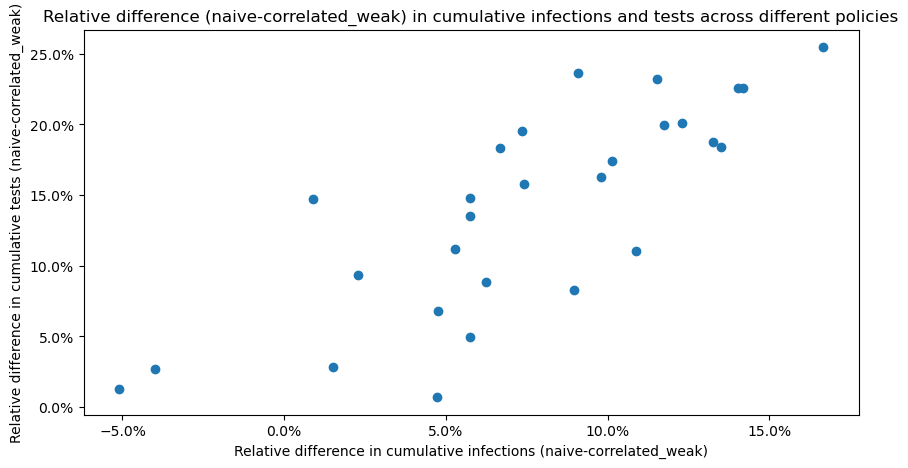

In [13]:
import matplotlib.ticker as mtick

df_sub = df[
    (df["init_prev"] == 0.01)
    # & (df["num_groups"] != 1)
    & (df["alpha"] == 2.0)
    & (df["distancing_scale"] == 50)
]

init_prev_values = np.unique(df["init_prev"])
colordict = {
    0.001: "green",
    0.01: "blue",
    0.1: "red"
}
markerdict = {
    6.0: "*",
    7.0: "^",
    6.5: "o"
}

fillstyledict = {
    2.0: "none",
    5.0: "full",
}


for pm1, pm2 in zip(["naive", "naive"], ["correlated", "correlated_weak"]):

    plt.figure(figsize=(10,5))
    for _, row in df_sub.iterrows():
        plt.scatter(
            row[f"cumInfections_diff_rel_{pm1}_{pm2}"], 
            row[f"cum_num_tests_diff_rel_{pm1}_{pm2}"], 
            color="tab:blue",
        )


    # plt.hlines(0,-0.3, 0.4, color="gray", linestyle="--")
    # plt.vlines(0,-0.1,0.3, color="gray", linestyle="--")
    plt.xlabel(f"Relative difference in cumulative infections ({pm1}-{pm2})")
    plt.ylabel(f"Relative difference in cumulative tests ({pm1}-{pm2})")

    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    # plt.xscale('log')

    plt.title(f"Relative difference ({pm1}-{pm2}) in cumulative infections and tests across different policies")
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # plt.savefig("../../figures/relative_diff.pdf", bbox_inches='tight')

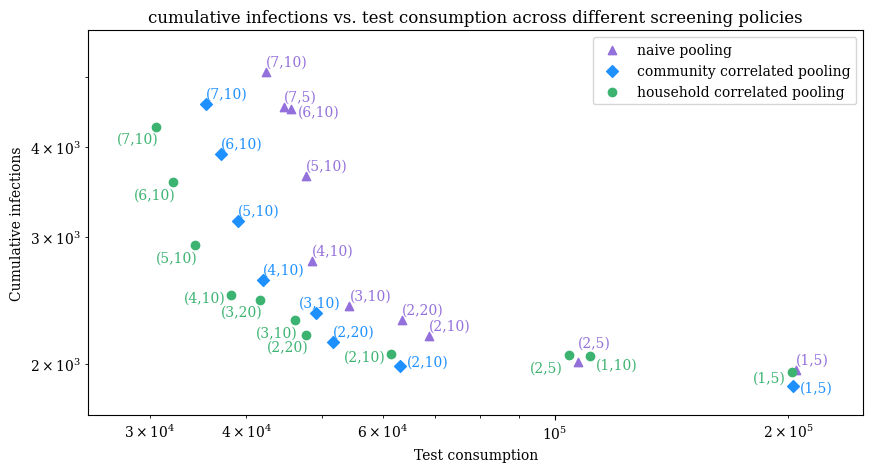

In [70]:
pooling_methods = ["naive", "correlated_weak", "correlated"]

df_sub = df[
    (df["init_prev"] == 0.01)
    & (df["distancing_scale"] == 50)
    & (df["alpha"] == 2.0)
]

init_prev_values = np.unique(df["init_prev"])

markerdict = { # screening frequency
    "naive": "^",
    "correlated": "o",
    "correlated_weak": "D"   
}

legends_dict = {
    "naive": "naive pooling",
    "correlated": "household correlated pooling",
    "correlated_weak": "community correlated pooling",
}

colors = {
    "naive": "mediumpurple",
    "correlated": "mediumseagreen",
    "correlated_weak": "dodgerblue",
}

plt.rcParams["font.family"] = 'serif'
plt.figure(figsize=(10,5))
legends = {}

all_results = defaultdict(list)
pareto_results = defaultdict(list)

texts = []



for pooling_method in pooling_methods:

    for row_idx, row in df_sub.iterrows():
        result_single = [row[f"cum_num_tests_{pooling_method}_mean"], row[f"cumInfections_{pooling_method}_mean"], row["num_groups"], row["pool_size"]]
        all_results[pooling_method].append(result_single)
    
    # sort pareto_np and pareto_cp by num_tests in ascending order
    # in each np/cp list, the point with the smallest num_tests cannot be dominated by any other point
    all_results[pooling_method].sort(key=lambda x: x[0])

    # then, iterate through the sorted list and keep only points not dominated by the previous point
    # it suffices to compare the kth with the k-1 th point only, because k-1 th point is not dominated by any point before it (ie must have lower cum infections)
    # so if the kth point has lower cum infections than the k-1 th point, then it has lower cum infections than (is not dominated by) any point before it
    pareto_results[pooling_method] = [all_results[pooling_method][0]]
    for i in range(1, len(all_results[pooling_method])):
        if all_results[pooling_method][i][1] < pareto_results[pooling_method][-1][1]:
            pareto_results[pooling_method].append(all_results[pooling_method][i])
    
    for i in range(len(pareto_results[pooling_method])):
        num_tests, cum_infections, num_groups, pool_size = pareto_results[pooling_method][i]
        scatter = plt.scatter(
            num_tests,
            cum_infections,
            color=colors[pooling_method],
            marker=markerdict[pooling_method],
        )
        if num_groups == 1:
            legends[legends_dict[pooling_method]] = scatter
        if pooling_method == "correlated":
            if num_groups == 4 and pool_size == 10:
                plt.annotate(f"({num_groups},{pool_size})", (num_tests*(0.87), cum_infections*(0.98)), color=colors[pooling_method])
            elif num_groups == 2 and pool_size == 10:
                plt.annotate(f"({num_groups},{pool_size})", (num_tests*(0.87), cum_infections*(0.98)), color=colors[pooling_method])
            elif num_groups == 1 and pool_size == 10:
                plt.annotate(f"({num_groups},{pool_size})", (num_tests*1.02, cum_infections*(0.96)), color=colors[pooling_method])
            elif num_groups == 1 and pool_size == 5:
                plt.annotate(f"({num_groups},{pool_size})", (num_tests*0.89, cum_infections*(0.97)), color=colors[pooling_method])
            else:
                plt.annotate(f"({num_groups},{pool_size})", (num_tests*(0.89), cum_infections*(0.95)), color=colors[pooling_method])
        elif pooling_method == "correlated_weak":
            if num_groups == 3 and pool_size == 10:
                plt.annotate(f"({num_groups},{pool_size})", (num_tests*0.95, cum_infections*1.02), color=colors[pooling_method])
            elif num_groups == 1 and pool_size == 5:
                plt.annotate(f"({num_groups},{pool_size})", (num_tests*1.02, cum_infections*0.98), color=colors[pooling_method])
            elif num_groups == 2 and pool_size == 10:
                plt.annotate(f"({num_groups},{pool_size})", (num_tests*1.02, cum_infections), color=colors[pooling_method])
            else:
                plt.annotate(f"({num_groups},{pool_size})", (num_tests, cum_infections*1.02), color=colors[pooling_method])
        else:
            if num_groups == 6 and pool_size == 10:
                plt.annotate(f"({num_groups},{pool_size})", (num_tests*1.02, cum_infections*0.98), color=colors[pooling_method])
            elif num_groups == 2 and pool_size == 5:
                plt.annotate(f"({num_groups},{pool_size})", (num_tests, cum_infections*1.05), color=colors[pooling_method])
            else:
                plt.annotate(f"({num_groups},{pool_size})", (num_tests, cum_infections*1.02), color=colors[pooling_method])
        

plt.xlabel("Test consumption")
plt.ylabel("Cumulative infections")

plt.xlim(2.5*1e4, 2.5*1e5)
plt.ylim(1.7*1e3, 5.8*1e3)

from matplotlib.ticker import FormatStrFormatter, LogFormatterSciNotation
import matplotlib.ticker as mticker



plt.xscale('log')
plt.yscale('log')

# plt.gca().tick_params(axis='y', which='minor', bottom=False)


# plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

# locmaj = matplotlib.ticker.LogLocator(base=10, numticks=10) 
# plt.gca().yaxis.set_minor_locator(locmaj)

# plt.tick_params(axis="y", which="minor")
# f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
# g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
# plt.gca().yaxis.set_minor_formatter(mticker.FuncFormatter(g))

# plt.gca().yaxis.set_minor_formatter(FormatStrFormatter("%.0e"))
# plt.gca().xaxis.set_major_formatter(FormatStrFormatter("%.0e"))

# plt.gca().yaxis.set_minor_formatter(LogFormatterSciNotation())


plt.legend(legends.values(), legends.keys(), loc='upper right')

plt.title("cumulative infections vs. test consumption across different screening policies")
plt.savefig("../../figures/diff_pareto.pdf", bbox_inches='tight')

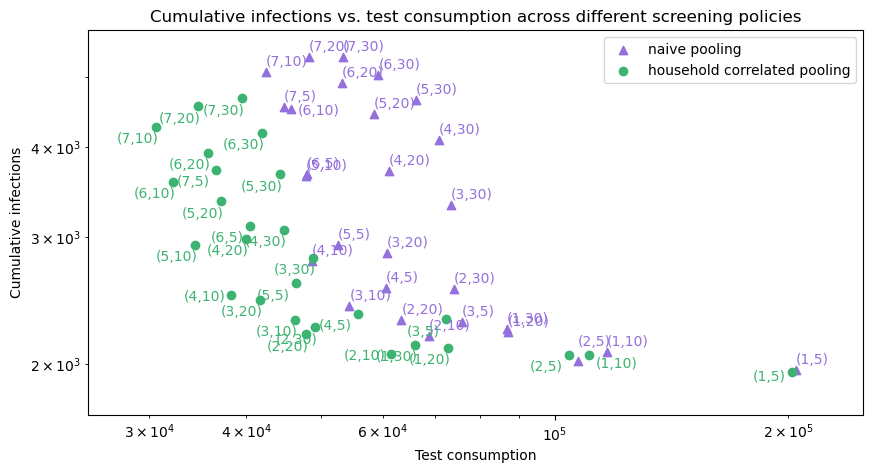

In [13]:
pooling_methods = ["naive", "correlated"]

df_sub = df[
    (df["init_prev"] == 0.01)
    & (df["distancing_scale"] == 50)
    & (df["alpha"] == 2.0)
]

init_prev_values = np.unique(df["init_prev"])

markerdict = { # screening frequency
    "naive": "^",
    "correlated": "o",
    "correlated_weak": "D"   
}

legends_dict = {
    "naive": "naive pooling",
    "correlated": "household correlated pooling",
    "correlated_weak": "community correlated pooling",
}

colors = {
    "naive": "mediumpurple",
    "correlated": "mediumseagreen",
    "correlated_weak": "dodgerblue",
}

plt.figure(figsize=(10,5))
legends = {}

all_results = defaultdict(list)
pareto_results = defaultdict(list)

texts = []

for pooling_method in pooling_methods:

    for row_idx, row in df_sub.iterrows():
        result_single = [row[f"cum_num_tests_{pooling_method}_mean"], row[f"cumInfections_{pooling_method}_mean"], row["num_groups"], row["pool_size"]]
        all_results[pooling_method].append(result_single)
    
    # # sort pareto_np and pareto_cp by num_tests in ascending order
    # # in each np/cp list, the point with the smallest num_tests cannot be dominated by any other point
    # all_results[pooling_method].sort(key=lambda x: x[0])

    # # then, iterate through the sorted list and keep only points not dominated by the previous point
    # # it suffices to compare the kth with the k-1 th point only, because k-1 th point is not dominated by any point before it (ie must have lower cum infections)
    # # so if the kth point has lower cum infections than the k-1 th point, then it has lower cum infections than (is not dominated by) any point before it
    # pareto_results[pooling_method] = [all_results[pooling_method][0]]
    # for i in range(1, len(all_results[pooling_method])):
    #     if all_results[pooling_method][i][1] < pareto_results[pooling_method][-1][1]:
    #         pareto_results[pooling_method].append(all_results[pooling_method][i])

    pareto_results[pooling_method] = all_results[pooling_method]
    
    for i in range(len(pareto_results[pooling_method])):
        num_tests, cum_infections, num_groups, pool_size = pareto_results[pooling_method][i]
        scatter = plt.scatter(
            num_tests,
            cum_infections,
            color=colors[pooling_method],
            marker=markerdict[pooling_method],
        )
        if num_groups == 1:
            legends[legends_dict[pooling_method]] = scatter
        if pooling_method == "correlated":
            if num_groups == 4 and pool_size == 10:
                plt.annotate(f"({num_groups},{pool_size})", (num_tests*(0.87), cum_infections*(0.98)), color=colors[pooling_method])
            elif num_groups == 2 and pool_size == 10:
                plt.annotate(f"({num_groups},{pool_size})", (num_tests*(0.87), cum_infections*(0.98)), color=colors[pooling_method])
            elif num_groups == 1 and pool_size == 10:
                plt.annotate(f"({num_groups},{pool_size})", (num_tests*1.02, cum_infections*(0.96)), color=colors[pooling_method])
            elif num_groups == 1 and pool_size == 5:
                plt.annotate(f"({num_groups},{pool_size})", (num_tests*0.89, cum_infections*(0.97)), color=colors[pooling_method])
            else:
                plt.annotate(f"({num_groups},{pool_size})", (num_tests*(0.89), cum_infections*(0.95)), color=colors[pooling_method])
        elif pooling_method == "correlated_weak":
            if num_groups == 3 and pool_size == 10:
                plt.annotate(f"({num_groups},{pool_size})", (num_tests*0.95, cum_infections*1.02), color=colors[pooling_method])
            elif num_groups == 1 and pool_size == 5:
                plt.annotate(f"({num_groups},{pool_size})", (num_tests*1.02, cum_infections*0.98), color=colors[pooling_method])
            elif num_groups == 2 and pool_size == 10:
                plt.annotate(f"({num_groups},{pool_size})", (num_tests*1.02, cum_infections), color=colors[pooling_method])
            else:
                plt.annotate(f"({num_groups},{pool_size})", (num_tests, cum_infections*1.02), color=colors[pooling_method])
        else:
            if num_groups == 6 and pool_size == 10:
                plt.annotate(f"({num_groups},{pool_size})", (num_tests*1.02, cum_infections*0.98), color=colors[pooling_method])
            elif num_groups == 2 and pool_size == 5:
                plt.annotate(f"({num_groups},{pool_size})", (num_tests, cum_infections*1.05), color=colors[pooling_method])
            else:
                plt.annotate(f"({num_groups},{pool_size})", (num_tests, cum_infections*1.02), color=colors[pooling_method])
        

plt.xlabel("Test consumption")
plt.ylabel("Cumulative infections")

plt.xlim(2.5*1e4, 2.5*1e5)
plt.ylim(1.7*1e3, 5.8*1e3)

from matplotlib.ticker import FormatStrFormatter, LogFormatterSciNotation
import matplotlib.ticker as mticker



plt.xscale('log')
plt.yscale('log')

plt.legend(legends.values(), legends.keys(), loc='upper right')

plt.title("Cumulative infections vs. test consumption across different screening policies")
plt.savefig("../../figures/diff_non_pareto.pdf", bbox_inches='tight')

Text(0.5, 1.0, 'Cumulative infections vs. test consumption across different policies')

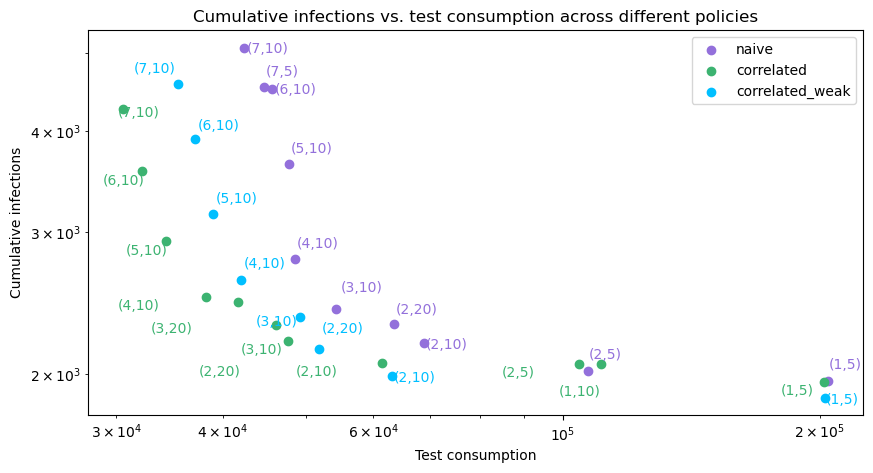

In [ ]:
pooling_methods = ["naive", "correlated", "correlated_weak"]

df_sub = df[
    (df["init_prev"] == 0.01)
    & (df["distancing_scale"] == 50)
    & (df["alpha"] == 2.0)
]

init_prev_values = np.unique(df["init_prev"])

markerdict = { # screening frequency
    1: "*",
    2: "^",
    3: "s",
    4: "P",
    5: "o",
    6: "X",
    7: "D"   
}

plt.figure(figsize=(10,5))
legends = {}

all_results = defaultdict(list)
pareto_results = defaultdict(list)

texts = []

for pooling_method in pooling_methods:

    for row_idx, row in df_sub.iterrows():
        result_single = [row[f"cum_num_tests_{pooling_method}_mean"], row[f"cumInfections_{pooling_method}_mean"], row["num_groups"], row["pool_size"]]
        all_results[pooling_method].append(result_single)
    
    # sort pareto_np and pareto_cp by num_tests in ascending order
    # in each np/cp list, the point with the smallest num_tests cannot be dominated by any other point
    all_results[pooling_method].sort(key=lambda x: x[0])

    # then, iterate through the sorted list and keep only points not dominated by the previous point
    # it suffices to compare the kth with the k-1 th point only, because k-1 th point is not dominated by any point before it (ie must have lower cum infections)
    # so if the kth point has lower cum infections than the k-1 th point, then it has lower cum infections than (is not dominated by) any point before it
    pareto_results[pooling_method] = [all_results[pooling_method][0]]
    for i in range(1, len(all_results[pooling_method])):
        if all_results[pooling_method][i][1] < pareto_results[pooling_method][-1][1]:
            pareto_results[pooling_method].append(all_results[pooling_method][i])
    
    for i in range(len(pareto_results[pooling_method])):
        num_tests, cum_infections, num_groups, pool_size = pareto_results[pooling_method][i]
        scatter = plt.scatter(
            num_tests,
            cum_infections,
            color=colors[pooling_method],
        )
        if num_groups == 1:
            legends[pooling_method] = scatter
        if pooling_method == "correlated":
            # texts.append(plt.text(num_tests-3000, cum_infections-100, f"({num_groups},{pool_size})", color=colors[pooling_method]))
            texts.append(plt.text(num_tests*(0.89), cum_infections*(0.95), f"({num_groups},{pool_size})", color=colors[pooling_method]))
            
        else:
            # texts.append(plt.text(num_tests+100, cum_infections+30, f"({num_groups},{pool_size})", color=colors[pooling_method]))
            texts.append(plt.text(num_tests, cum_infections*1.02, f"({num_groups},{pool_size})", color=colors[pooling_method]))

        # plt.annotate(f"({num_groups},{pool_size})", (num_tests+100, cum_infections+30), color=colors[pooling_method])

adjust_text(
    texts, 
    # only_move={'points':'y', 'texts':'xy'}
    only_move={'text':'xy'},
    force_text = (0.001,0.05),
    force_static = (0.01, 0.01)
    # force_pull=(0.1, 0.1),
    # arrowprops=dict(arrowstyle='->', color='blue')
)

plt.xlabel("Test consumption")
plt.ylabel("Cumulative infections")

plt.xscale('log')
plt.yscale('log')

plt.legend(legends.values(), legends.keys(), loc='upper right')

plt.title("Cumulative infections vs. test consumption across different policies")
# plt.savefig("../../figures/diff.pdf", bbox_inches='tight')

Text(0.5, 1.0, 'Cumulative infections vs. test consumption across different policies')

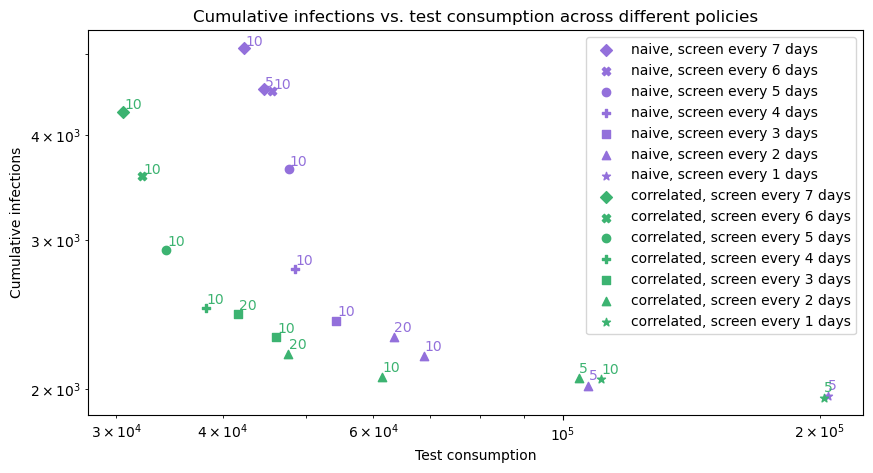

In [25]:
pooling_methods = ["naive", "correlated"]

df_sub = df[
    (df["init_prev"] == 0.01)
    & (df["distancing_scale"] == 50)
    & (df["alpha"] == 2.0)
]

init_prev_values = np.unique(df["init_prev"])

markerdict = { # screening frequency
    1: "*",
    2: "^",
    3: "s",
    4: "P",
    5: "o",
    6: "X",
    7: "D"
}

plt.figure(figsize=(10,5))
legends = {}

all_results = defaultdict(list)
pareto_results = defaultdict(list)

for pooling_method in pooling_methods:

    for row_idx, row in df_sub.iterrows():
        result_single = [row[f"cum_num_tests_{pooling_method}_mean"], row[f"cumInfections_{pooling_method}_mean"], row["num_groups"], row["pool_size"]]
        all_results[pooling_method].append(result_single)
    
    # sort pareto_np and pareto_cp by num_tests in ascending order
    # in each np/cp list, the point with the smallest num_tests cannot be dominated by any other point
    all_results[pooling_method].sort(key=lambda x: x[0])

    # then, iterate through the sorted list and keep only points not dominated by the previous point
    # it suffices to compare the kth with the k-1 th point only, because k-1 th point is not dominated by any point before it (ie must have lower cum infections)
    # so if the kth point has lower cum infections than the k-1 th point, then it has lower cum infections than (is not dominated by) any point before it
    pareto_results[pooling_method] = [all_results[pooling_method][0]]
    for i in range(1, len(all_results[pooling_method])):
        if all_results[pooling_method][i][1] < pareto_results[pooling_method][-1][1]:
            pareto_results[pooling_method].append(all_results[pooling_method][i])
    
    for i in range(len(pareto_results[pooling_method])):
        num_tests, cum_infections, num_groups, pool_size = pareto_results[pooling_method][i]
        scatter = plt.scatter(
            num_tests,
            cum_infections,
            marker=markerdict[num_groups],
            color=colors[pooling_method],
        )
        legends[f"{pooling_method}, screen every {num_groups} days"] = scatter
        plt.annotate(f"{pool_size}", (num_tests+100, cum_infections+30), color=colors[pooling_method])

plt.xlabel("Test consumption")
plt.ylabel("Cumulative infections")

plt.xscale('log')
plt.yscale('log')

plt.legend(legends.values(), legends.keys(), loc='upper right')

plt.title("Cumulative infections vs. test consumption across different policies")
# plt.savefig("../../figures/diff.pdf", bbox_inches='tight')